## **Plant Doctor**

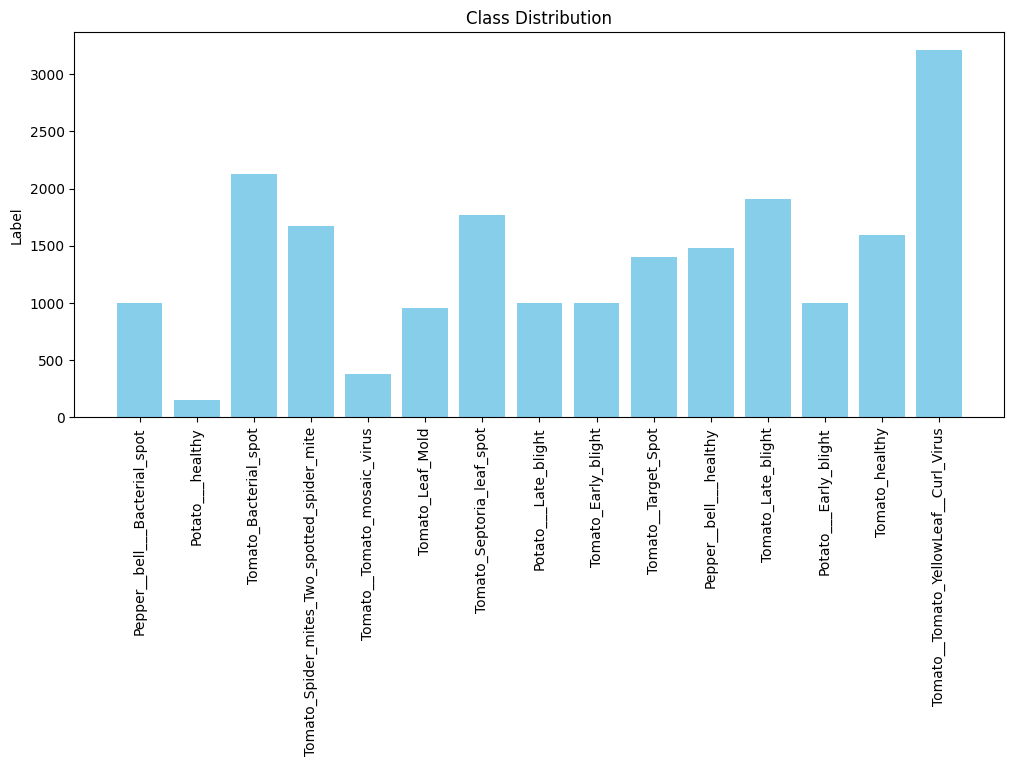

In [20]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("../plantdisease/PlantVillage")

labels = os.listdir(path)
counts = [len(os.listdir(os.path.join(path, label))) for label in labels]

plt.figure(figsize=(12, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel("Image count")
plt.ylabel("Label")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

In [104]:
import torch
from torch.utils import data
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

class Data(data.Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        return img, sample.label

In [118]:
from sklearn.model_selection import train_test_split

def load_data(pth):
    data = []
    
    for p in path.iterdir():
        for image in  p.iterdir():
            if image.suffix.lower() == ".jpg":
                data.append((image, image.parents[0].stem))
    
    return pd.DataFrame(data, columns=['path', 'label'])

df = load_data(path)

train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.1)

print(train.shape)
print(valid.shape)
print(test.shape)

train = Data(train)
valid = Data(valid)
test = Data(test)

(14857, 2)
(1651, 2)
(4128, 2)


In [119]:
import torch


def get_dataset_stats(ds):
    '''
    Inputs:
        ds   - pytorch dataset
             - the sample shape [3, W, H]
             - torch tensor, values in range (0, 1)
        
    Outputs:
        dataset mean value per color channel 
        dataset standard deviation per color channel 
    '''
    all_pixels = torch.cat([img.unsqueeze(0) for img, _ in ds], dim=0)  # Shape: [N, 3, W, H]    
    ds_mean = all_pixels.mean(dim=[0, 2, 3]) 
    ds_std = all_pixels.std(dim=[0, 2, 3])

    return list(ds_mean), list(ds_std)


mean, std = get_dataset_stats(train)
print(f'Dataset stats\n  mean:\t {mean}\n  std:\t {std}' )


: 

In [110]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(),
    A.Affine(rotate=(-180,180), p=.5),
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2()
])

In [111]:
train.transforms = train_transform

train[0]

TypeError: image must be numpy array type